In [2]:
from math import sqrt
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.layers import LSTM
from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
import datetime
import seaborn as sns
from scipy import stats

In [3]:
def scale(dataset,col_name, output_array=False):
    """Standard Z score scaler"""
    array = dataset[col_name].to_numpy()
    mean = np.mean(array)
    std = np.std(array)
    scaled = (array-mean)/std
    if output_array:
        return scaled
    else:
        return scaled, mean, std 

In [4]:
def series_to_supervised(data, n_in=1, n_out=1, variable_num = 0,  dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
    data: Sequence of observations as a list or NumPy array.
    n_in: Number of lag observations as input (X).
    n_out: Number of observations as output (y).
    dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
    Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names+=[('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df[variable_num].shift(-i))
        if i == 0:
            names.append('var1(t)')
        else:
            names.append('var%d(t+%d)' % (1, i))
    
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg, names

In [5]:
def random_date(array, lockdown=False):
    """ Choose a random date within lockdown or out of lockdown."""
    if lockdown:
        return np.random.choice(array[(array > pd.to_datetime('2020-03-24')) & (array < pd.to_datetime('2020-06-23')) ])
    else:
        #ensure a years worth of hourly data is available for training.
        array = pd.to_datetime(array[(24*365):])
        
        # 2020-01-01 ensures only non-lockdown entries will be considered
        return np.random.choice(array[array < pd.to_datetime('2020-01-01')])

In [6]:
def split_by_date( dataset , reframed_data, date, days_prior=60):
    
    """ Split reframed data by specific date, days refers to the number 
    of days after the specified date the test set will contain.
    days prior refers to the number of days used to train the model """
    
    #get values from reframed data
    values = reframed_data.values
    
    #convert string into datetime
    date = pd.to_datetime(date)
    
    #create new dataframe
    df = dataset.reset_index().rename(columns = {'index':'date'})
    
    #ensure dates are in datetime format
    df['date'] = pd.to_datetime(df['date'])
    
    #find index for date
    date1_index = df.index[df['date'] == date1 ][0]
    
    #set train values to be all data upto given date 
    train = values[ date1_index - n_hours - (24*days_prior) : date1_index - n_hours, :]
    
    #remove training dataset so that tests can be done on the remaining datapoints 
    leftover_before = values[ : date1_index - n_hours - (24 * days_prior) , :]
    leftover_after = values[ date1_index - n_hours : , :]

    #get index of second date is 1 month into future
    date2_index = date1_index + (30 * 24)

    #test set two months after specified date
    test = values[ ( date1_index - n_hours ) : (date2_index - n_hours)  + 1 , :]
    
    #get specific dates for test period
    dates = df.date.to_numpy()
    specific_dates = dates[ date1_index  : date2_index+1  ]
    
    if leftover_before.shape[0] > leftover_after.shape[0]:
        
        return train , test, specific_dates, leftover_before
    
    else:
        return train , test, specific_dates, leftover_after

In [7]:
def reshape(data, n_seq, n_steps, n_features):
    """ Reshape puts data in apprpriate format for LSTM_CNN usage
    [samples, n_seqs, timesteps, features] """
    n_obs = n_hours * n_features

    #split according to lag columns and output
    data_X, data_y = data[:, :n_obs], data[:, n_obs:]
         
    # reshape input to be 3D [samples, timesteps, features]
    data_X_r = data_X.reshape((data_X.shape[0], n_seq , n_steps, n_features))

    return data_X, data_y , data_X_r 

In [8]:
def inverse_scale(array,mean,std):
    """ Inversion of Standard scaler """
    inverse = (array*std) + mean 
    return inverse

In [9]:
def CNN_LSTM_model(cells, filter_no, filter_size, dropout, layers):
    # define model
    model = Sequential()
    model.add(TimeDistributed(Conv1D(filters = filter_no, padding='same', kernel_size=filter_size, activation='relu'), input_shape=(None, n_steps, n_features)))
    if layers == 1:
        model.add(TimeDistributed(Conv1D(filters = filter_no, padding='same', kernel_size=filter_size, activation='relu'), input_shape=(None, n_steps, n_features)))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    model.add(TimeDistributed(Dropout(dropout)))
    
    if layers == 2:
        filter_no = int ( filter_no / 2 )
        filter_size += 2
        dropout += 0.1
        model.add(TimeDistributed(Conv1D(filters = filter_no, padding='same', kernel_size=filter_size, activation='relu'), input_shape=(None, n_steps, n_features)))
        model.add(TimeDistributed(Conv1D(filters = filter_no, padding='same', kernel_size=filter_size, activation='relu'), input_shape=(None, n_steps, n_features)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
        model.add(TimeDistributed(Dropout(dropout)))
    
    if layers == 3:
        filter_no = int ( filter_no / 2 )
        filter_size += 2
        dropout += 0.1
        model.add(TimeDistributed(Conv1D(filters = filter_no, padding='same', kernel_size=filter_size, activation='relu'), input_shape=(None, n_steps, n_features)))
        model.add(TimeDistributed(Conv1D(filters = filter_no, padding='same', kernel_size=filter_size, activation='relu'), input_shape=(None, n_steps, n_features)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
        model.add(TimeDistributed(Dropout(dropout)))
        
        filter_no = int ( filter_no / 2 )
        filter_size += 2
        dropout += 0.1
        model.add(TimeDistributed(Conv1D(filters = filter_no, padding='same', kernel_size=filter_size, activation='relu'), input_shape=(None, n_steps, n_features)))
        model.add(TimeDistributed(Conv1D(filters = filter_no, padding='same', kernel_size=filter_size, activation='relu'), input_shape=(None, n_steps, n_features)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling1D(pool_size=1)))
        model.add(TimeDistributed(Dropout(dropout)))
    
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(cells, activation = 'relu',input_shape=(train_X_r.shape[1], train_X_r.shape[2])))
    model.add(Dense(n_hours, activation = 'relu'))
    model.add(Dense(n_hours_out))
    model.compile(loss='mse', optimizer='adam')
    
    return model

In [10]:
def hour_predictor(test_r, index , timesteps):
    """ Rolling one hour prediction: uses previous 
    1 hour predictions to predict 1 hour ahead """
    
    #starting sequence used to get first prediction. 
    start = test_r[index].reshape(1,n_hours,n_features)
    
    #empty array to store results 
    results = []
    
    #get first prediction
    result = model.predict(start)[0][0]
    
    #record it 
    results.append(result)
    
    for i in range (1,timesteps):

        #shift window one time step
        start = np.delete(start[0],0,0)
        next_ts = test_r[index+i][2]
        start = np.append(start,next_ts).reshape(1,n_hours,n_features)

        #add prediction
        start[0][n_hours-1][0] = result

        #make new prediction
        result = model.predict(start)[0][0]

        results.append(result)
        
    return np.array(results)

In [11]:
# load dataset

dataset = pd.read_csv('./MCC_combined.csv', header=0, index_col=0)

#conver days column into one-hot-encoded variable
days =['Mon','Tue','Wed','Thurs','Fri','Sat','Sun']
data = pd.get_dummies(dataset['day_of_week'])
data.columns = days
dataset  = dataset.join(data)

#get all dates
all_dates = pd.to_datetime(dataset.index.to_numpy())


#scale continuous variables --> ['temp', 'ws', 'wd', 'Volume']
continuous_vars = ['temp', 'ws', 'wd', 'Volume']
for i in continuous_vars:
    dataset[i] = scale(dataset,i,output_array=True)
    
# scale NO2 keep mean and std for inverse scaling
no2, mean, std, = scale(dataset,'NO2',output_array=False)
dataset['NO2'] = no2

#chose variables

#-----NO2 only 
# ['NO2']

#-----NO2 + traffic volume

#['NO2','Volume']


#------NO2 + meteorological

#['NO2', 'ws' ,'temp','wd_1', 'wd_2', 'wd_3', 'wd_4']


#------ ALL VARIABLES

#['NO2', 'ws' ,'temp','wd_1', 'wd_2', 'wd_3', 'wd_4', 'Volume','Mon', 'Tue', 'Wed',
       #'Thurs', 'Fri', 'Sat', 'Sun']


dataset.head()

,NO2,temp,ws,wd,Volume,Lockdown,hour,day_of_week,month,day,...,wd_2,wd_3,wd_4,Mon,Tue,Wed,Thurs,Fri,Sat,Sun
2016-03-03 12:00:00,2.045647,-0.773055,-0.902819,1.146580,0.951586,0,12,3,3,3,...,0,0,1,0,0,0,1,0,0,0
2016-03-03 13:00:00,1.634783,-0.421667,0.024130,1.177822,0.951586,0,13,3,3,3,...,0,0,1,0,0,0,1,0,0,0
2016-03-03 14:00:00,0.961775,-0.351389,0.078657,1.093709,0.601488,0,14,3,3,3,...,0,0,1,0,0,0,1,0,0,0
2016-03-03 15:00:00,0.874943,-0.544652,-0.902819,0.854590,1.014103,0,15,3,3,3,...,0,1,0,0,0,0,1,0,0,0
2016-03-03 16:00:00,1.500129,-0.878471,-0.739240,0.068739,1.314187,0,16,3,3,3,...,0,1,0,0,0,0,1,0,0,0


In [12]:
# paramter ranges
FILTERS = [32,64]
FILTER_SIZE = [2]
HOURS_BEFORE = [24]
BATCH_SIZE = [32]
N_SEQ = [1,2,3]
CELLS = [24]
DROPOUT= [0.2]
EPOCHS = [100]
TRAIN_SIZE = [30]
LAYERS = [0,1,2,3]
VARIABLES = [['NO2'],['NO2','Volume'], 
            ['NO2', 'ws' ,'temp','wd_1', 'wd_2', 'wd_3', 'wd_4'],
            ['NO2', 'ws' ,'temp','wd_1', 'wd_2', 'wd_3', 'wd_4', 'Volume','Mon', 'Tue', 'Wed',
             'Thurs', 'Fri', 'Sat', 'Sun']]
TIMESTEPS = 1 # for rolling prediction
LOCKDOWN = False
rdm_date = False
plot_days = 30


if rdm_date:
    #choose a random date 
    DATE = random_date(all_dates,lockdown=LOCKDOWN)
else:
    DATE =  '2020-03-24' #First lockdown
    DATE1 = '2020-02-24' #Month Before Lockdown
    
results = []

print ('runs:', len(HOURS_BEFORE)*len(BATCH_SIZE)
      *len(CELLS)* len(DROPOUT) * len(EPOCHS) * len(TRAIN_SIZE)
      * len(VARIABLES)* len(N_SEQ) * len(LAYERS) * 3)

runs: 144


In [13]:
# #create new dataframe
# df = dataset.reset_index().rename(columns = {'index':'date'})

# #ensure dates are in datetime format
# df['date'] = pd.to_datetime(df['date'])

# #find index for date
# df[df['date'] >= DATE ]

hb:24, ts:30, f:32, fs:2, n_seq:1, e:100, bs:32, c:24, vars:1, layers:0  
1, 0, RMSE:0.6397566199302673, MAPE: 0.49345993995666504 
2, 1, RMSE:0.699046790599823, MAPE: 0.5679960250854492 
3, 2, RMSE:0.6740734577178955, MAPE: 0.6621494293212891 


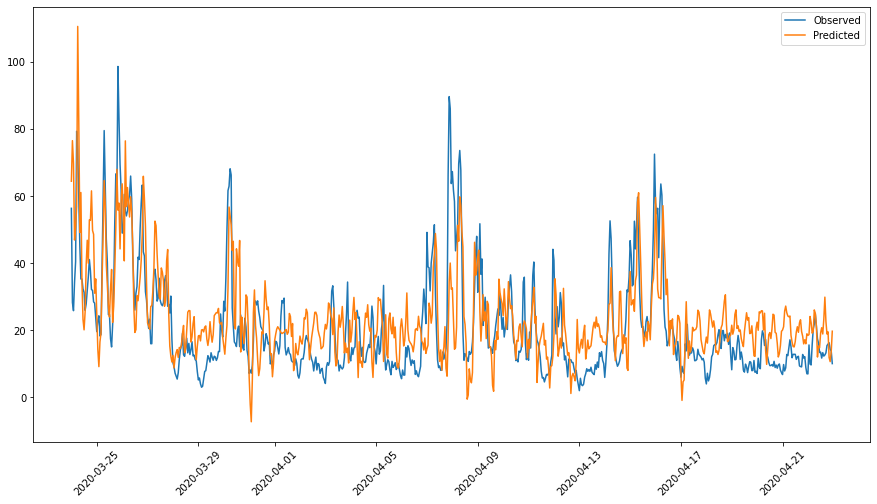

hb:24, ts:30, f:32, fs:2, n_seq:2, e:100, bs:32, c:24, vars:1, layers:0  
4, 0, RMSE:0.5957324504852295, MAPE: 0.5324952602386475 
5, 1, RMSE:0.5803008675575256, MAPE: 0.476814329624176 
6, 2, RMSE:0.5936044454574585, MAPE: 0.4942149519920349 


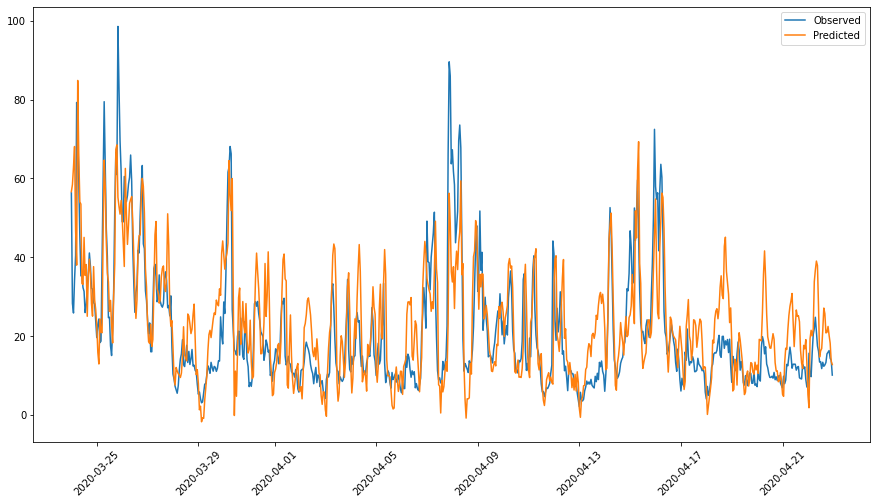

hb:24, ts:30, f:32, fs:2, n_seq:3, e:100, bs:32, c:24, vars:1, layers:0  
7, 0, RMSE:0.5726495981216431, MAPE: 0.5952232480049133 
8, 1, RMSE:0.6620287895202637, MAPE: 0.7289789319038391 
9, 2, RMSE:0.5191527009010315, MAPE: 0.3917940557003021 


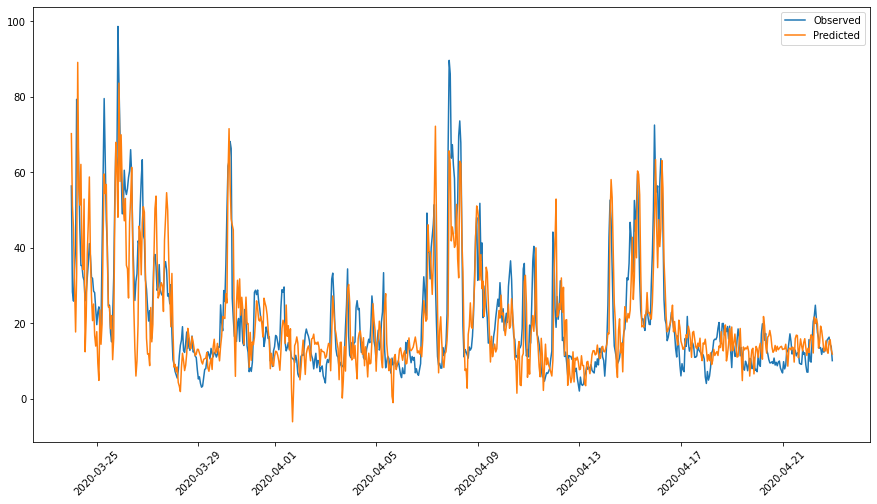

hb:24, ts:30, f:64, fs:2, n_seq:1, e:100, bs:32, c:24, vars:1, layers:0  
10, 0, RMSE:0.8215873837471008, MAPE: 0.7462117671966553 
11, 1, RMSE:0.7566978335380554, MAPE: 0.7023946642875671 
12, 2, RMSE:0.6902269721031189, MAPE: 0.5363175868988037 


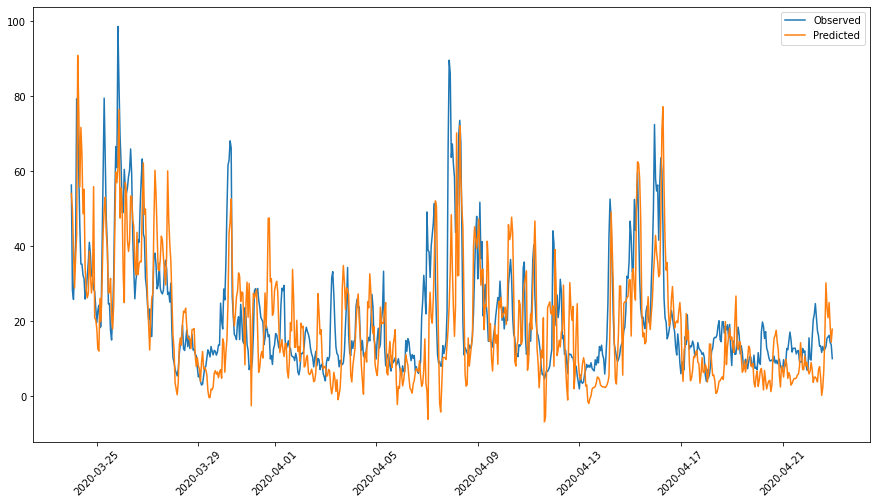

hb:24, ts:30, f:64, fs:2, n_seq:2, e:100, bs:32, c:24, vars:1, layers:0  
13, 0, RMSE:0.8809531927108765, MAPE: 0.7406665086746216 
14, 1, RMSE:0.568875789642334, MAPE: 0.49596500396728516 
15, 2, RMSE:0.5868854522705078, MAPE: 0.4143030047416687 


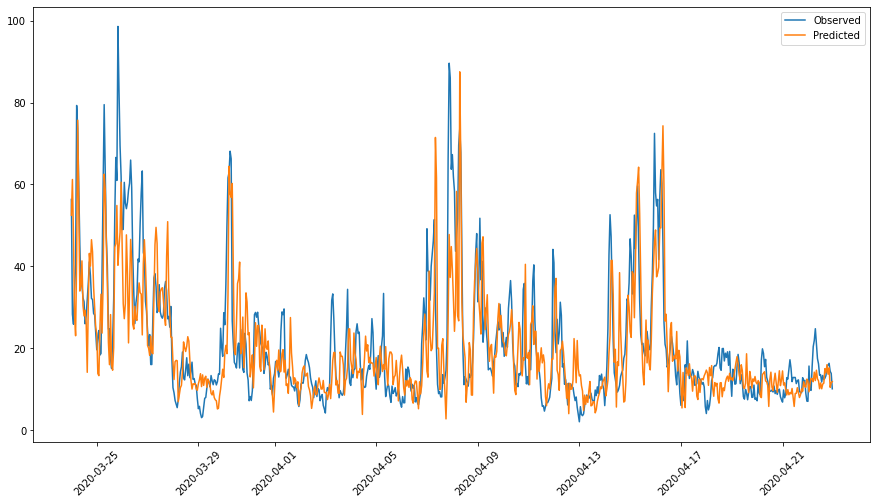

hb:24, ts:30, f:64, fs:2, n_seq:3, e:100, bs:32, c:24, vars:1, layers:0  
16, 0, RMSE:0.5243626832962036, MAPE: 0.4737374782562256 
17, 1, RMSE:0.5408079028129578, MAPE: 0.398436576128006 
18, 2, RMSE:0.7175406813621521, MAPE: 0.8732764720916748 


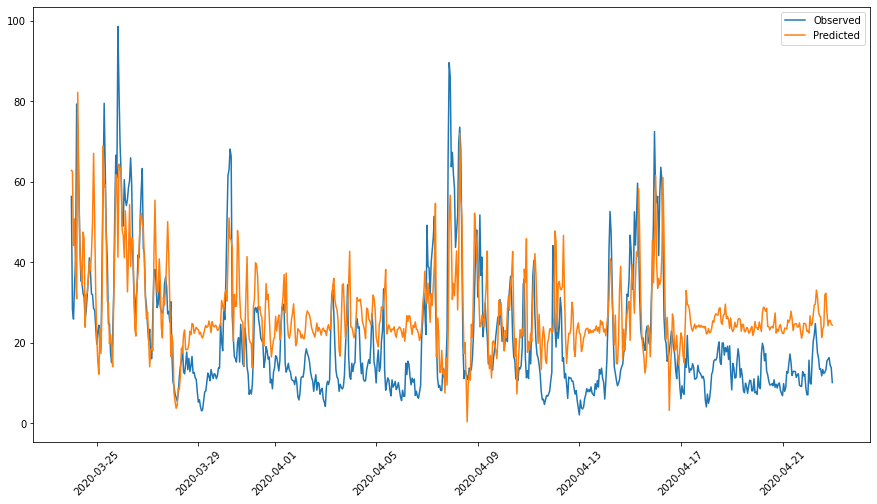

hb:24, ts:30, f:32, fs:2, n_seq:1, e:100, bs:32, c:24, vars:1, layers:1  
19, 0, RMSE:0.7086789011955261, MAPE: 0.8567360043525696 
20, 1, RMSE:0.5529270172119141, MAPE: 0.5004295110702515 
21, 2, RMSE:0.5289885401725769, MAPE: 0.579635500907898 


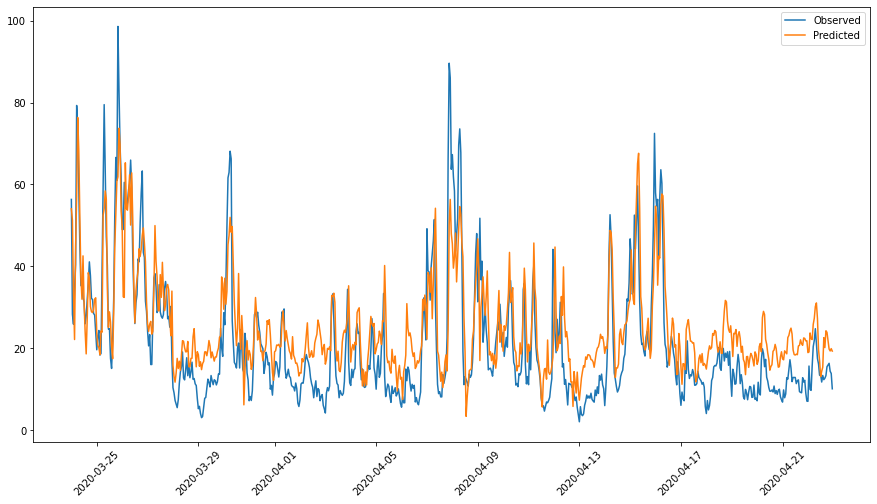

hb:24, ts:30, f:32, fs:2, n_seq:2, e:100, bs:32, c:24, vars:1, layers:1  
22, 0, RMSE:0.5342692732810974, MAPE: 0.4783945381641388 
23, 1, RMSE:0.6672084331512451, MAPE: 0.7564409375190735 
24, 2, RMSE:0.6485018730163574, MAPE: 0.7172958850860596 


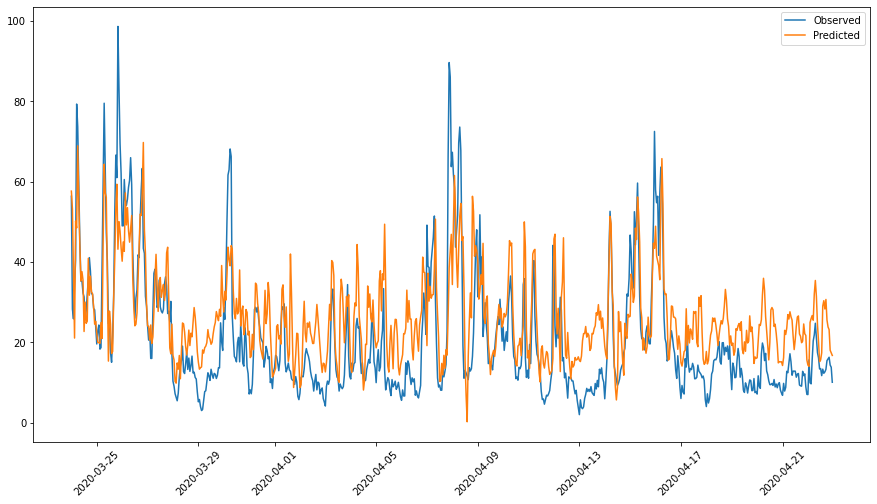

hb:24, ts:30, f:32, fs:2, n_seq:3, e:100, bs:32, c:24, vars:1, layers:1  
25, 0, RMSE:0.6027674674987793, MAPE: 0.6742894053459167 
26, 1, RMSE:0.5431926846504211, MAPE: 0.529492199420929 
27, 2, RMSE:0.533087968826294, MAPE: 0.4924090504646301 


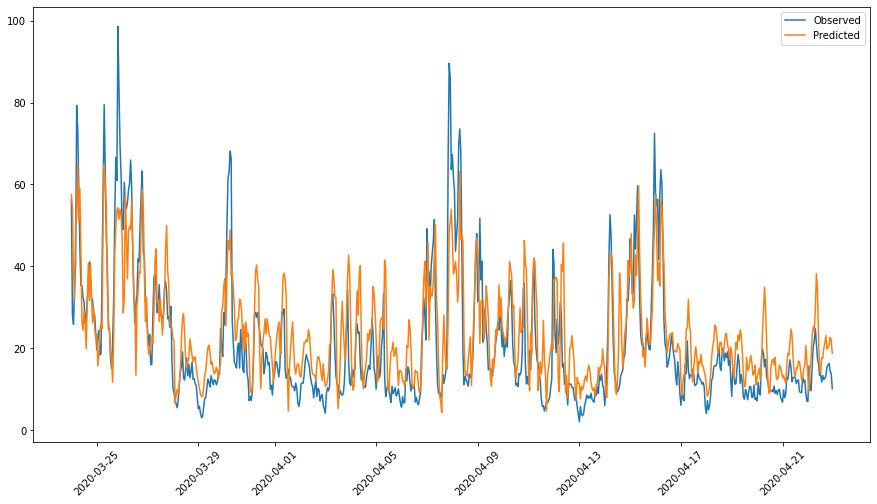

hb:24, ts:30, f:64, fs:2, n_seq:1, e:100, bs:32, c:24, vars:1, layers:1  
28, 0, RMSE:0.7267522811889648, MAPE: 0.8578517436981201 
29, 1, RMSE:0.5397076606750488, MAPE: 0.5455273389816284 
30, 2, RMSE:0.524709165096283, MAPE: 0.4042310118675232 


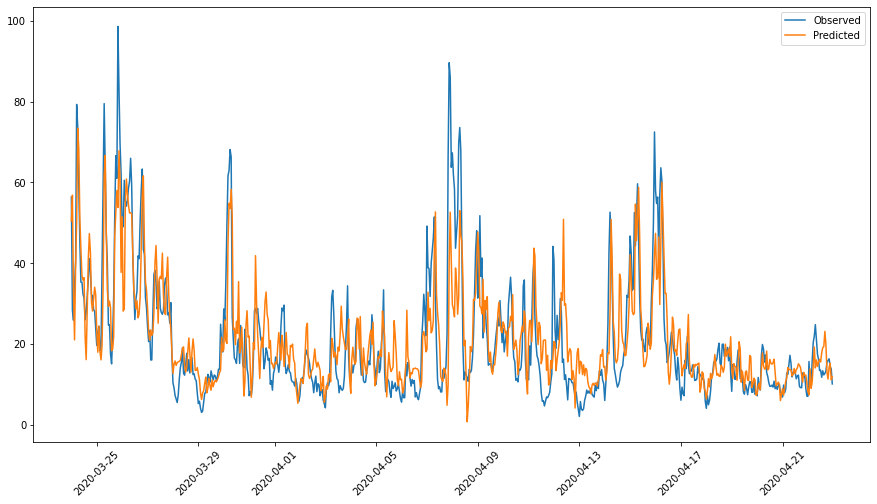

hb:24, ts:30, f:64, fs:2, n_seq:2, e:100, bs:32, c:24, vars:1, layers:1  
31, 0, RMSE:0.5299884676933289, MAPE: 0.3768618404865265 
32, 1, RMSE:0.49427884817123413, MAPE: 0.35876184701919556 
33, 2, RMSE:0.5869332551956177, MAPE: 0.5221627950668335 


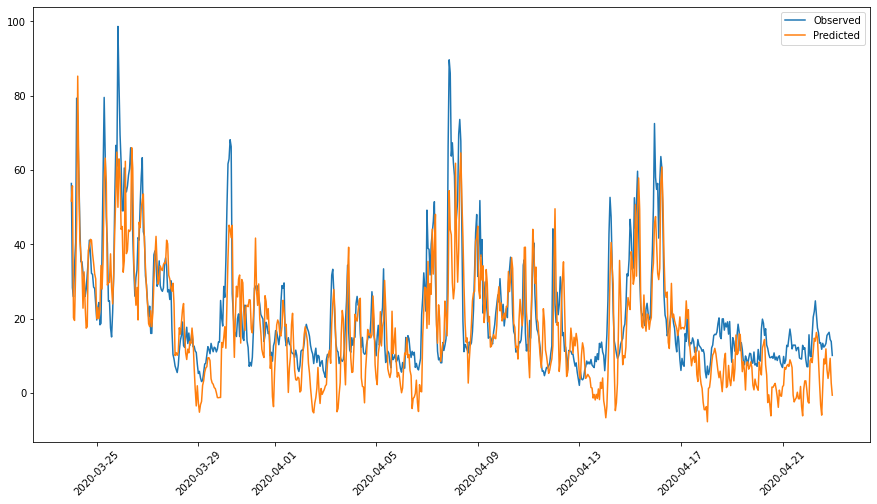

hb:24, ts:30, f:64, fs:2, n_seq:3, e:100, bs:32, c:24, vars:1, layers:1  
34, 0, RMSE:0.5790229439735413, MAPE: 0.5924922227859497 
35, 1, RMSE:0.50887531042099, MAPE: 0.48900339007377625 
36, 2, RMSE:0.6450715065002441, MAPE: 0.6884222626686096 


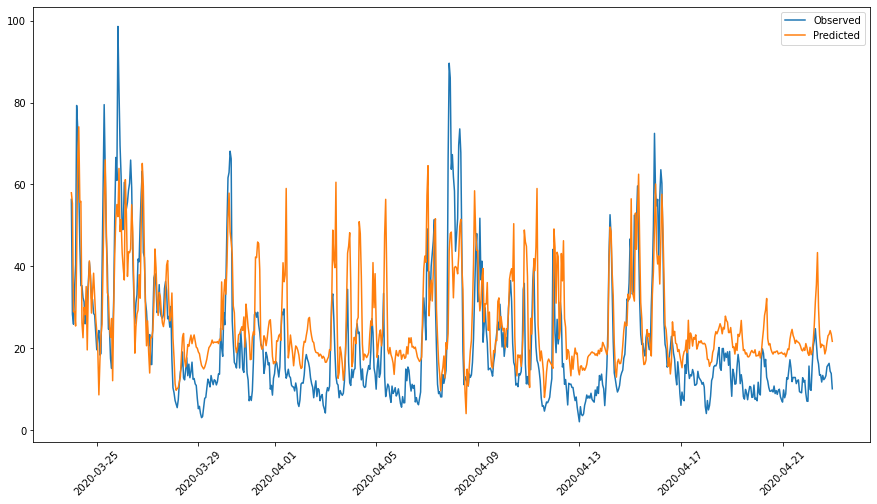

hb:24, ts:30, f:32, fs:2, n_seq:1, e:100, bs:32, c:24, vars:1, layers:2  
37, 0, RMSE:0.5905036330223083, MAPE: 0.6465164422988892 
38, 1, RMSE:0.6351391077041626, MAPE: 0.6917392015457153 
39, 2, RMSE:0.5364282131195068, MAPE: 0.5166863203048706 


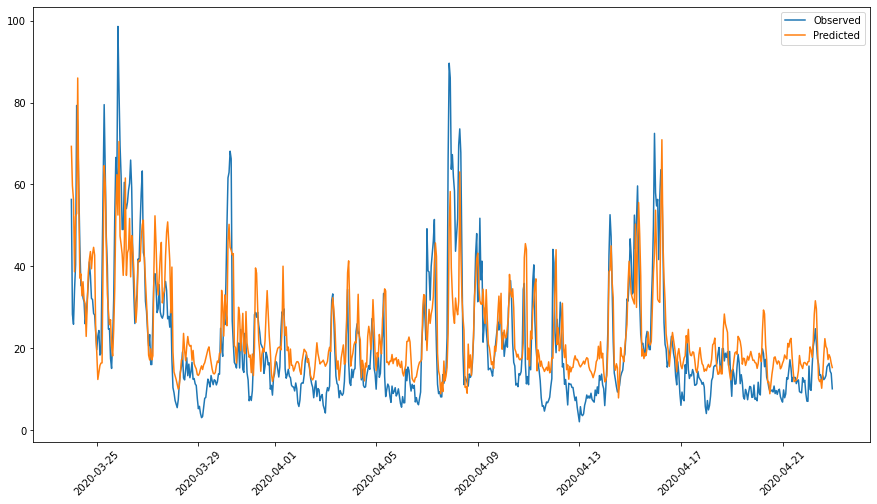

hb:24, ts:30, f:32, fs:2, n_seq:2, e:100, bs:32, c:24, vars:1, layers:2  
40, 0, RMSE:0.5070340037345886, MAPE: 0.4528399705886841 
41, 1, RMSE:0.5962246656417847, MAPE: 0.6978726983070374 
42, 2, RMSE:0.6198887228965759, MAPE: 0.521100640296936 


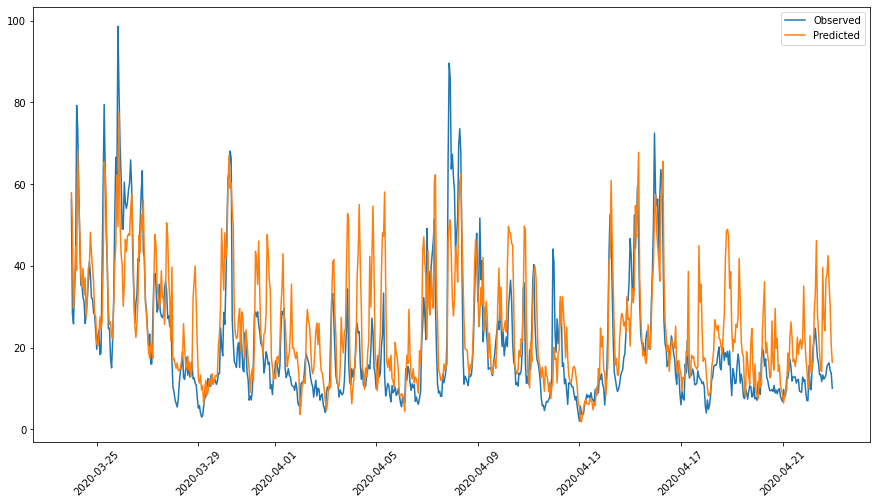

hb:24, ts:30, f:32, fs:2, n_seq:3, e:100, bs:32, c:24, vars:1, layers:2  
43, 0, RMSE:0.566097617149353, MAPE: 0.6631787419319153 
44, 1, RMSE:0.559082567691803, MAPE: 0.6090561747550964 
45, 2, RMSE:0.5829474329948425, MAPE: 0.7033632397651672 


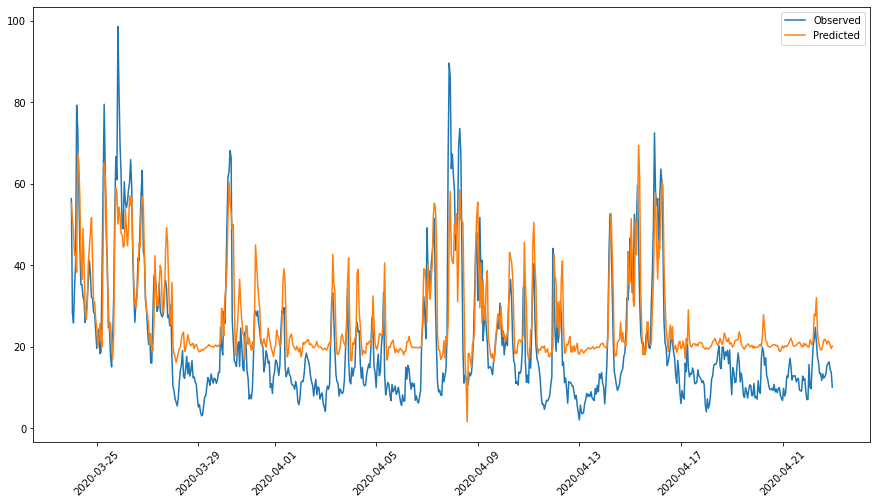

hb:24, ts:30, f:64, fs:2, n_seq:1, e:100, bs:32, c:24, vars:1, layers:2  
46, 0, RMSE:0.6502541899681091, MAPE: 0.7342783212661743 
47, 1, RMSE:0.5472906827926636, MAPE: 0.5372685790061951 
48, 2, RMSE:0.6383783221244812, MAPE: 0.6788922548294067 


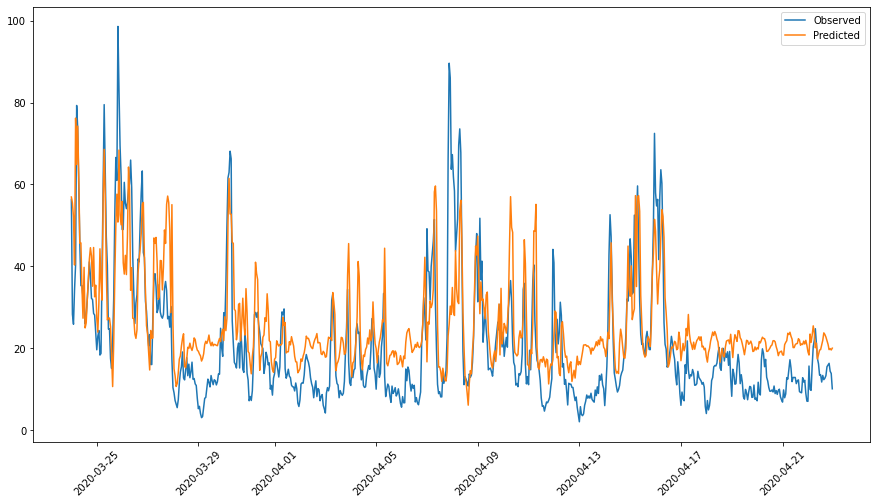

hb:24, ts:30, f:64, fs:2, n_seq:2, e:100, bs:32, c:24, vars:1, layers:2  
49, 0, RMSE:0.5288029313087463, MAPE: 0.4434715509414673 
50, 1, RMSE:0.7976568937301636, MAPE: 0.953369677066803 
51, 2, RMSE:0.6005497574806213, MAPE: 0.6014676094055176 


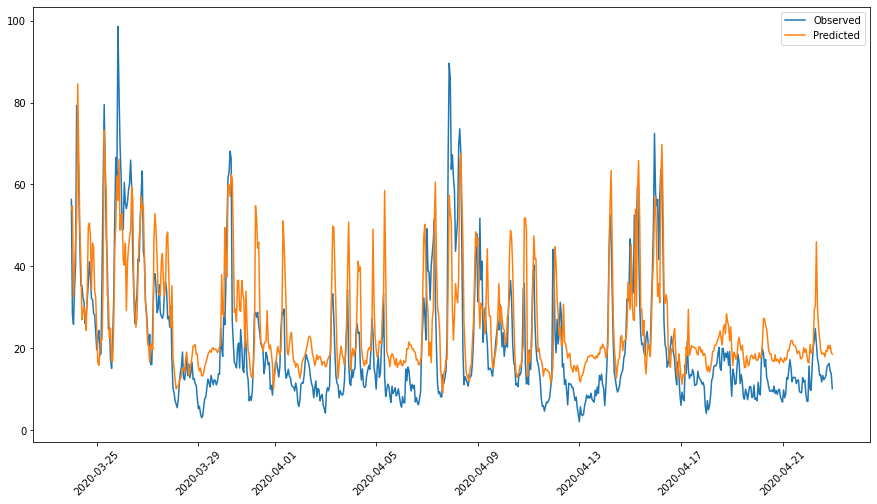

hb:24, ts:30, f:64, fs:2, n_seq:3, e:100, bs:32, c:24, vars:1, layers:2  
52, 0, RMSE:0.55743008852005, MAPE: 0.5895282626152039 
53, 1, RMSE:0.5306484699249268, MAPE: 0.4029723107814789 
54, 2, RMSE:0.755413293838501, MAPE: 0.974754810333252 


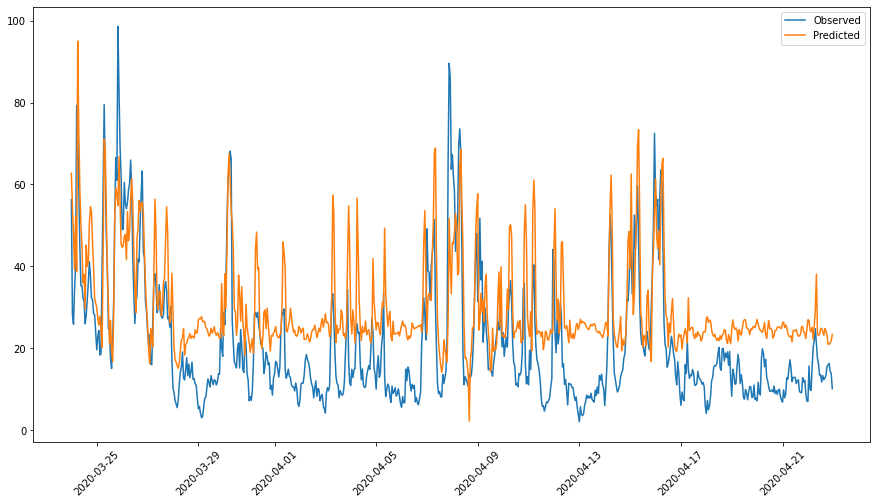

hb:24, ts:30, f:32, fs:2, n_seq:1, e:100, bs:32, c:24, vars:1, layers:3  
55, 0, RMSE:0.5048683881759644, MAPE: 0.5898107290267944 
56, 1, RMSE:0.4981379210948944, MAPE: 0.5369947552680969 
57, 2, RMSE:0.5040847659111023, MAPE: 0.56622713804245 


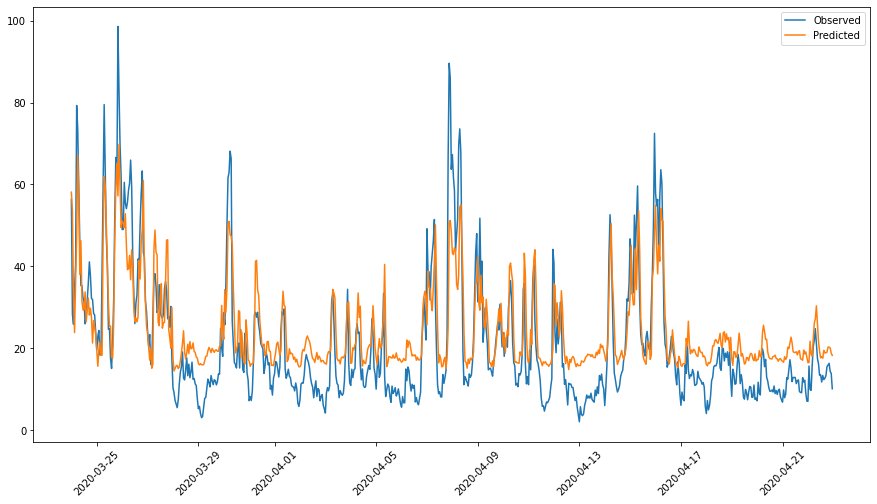

hb:24, ts:30, f:32, fs:2, n_seq:2, e:100, bs:32, c:24, vars:1, layers:3  
58, 0, RMSE:0.550593376159668, MAPE: 0.641554057598114 
59, 1, RMSE:0.5298798680305481, MAPE: 0.621140718460083 
60, 2, RMSE:0.5631809830665588, MAPE: 0.6993868350982666 


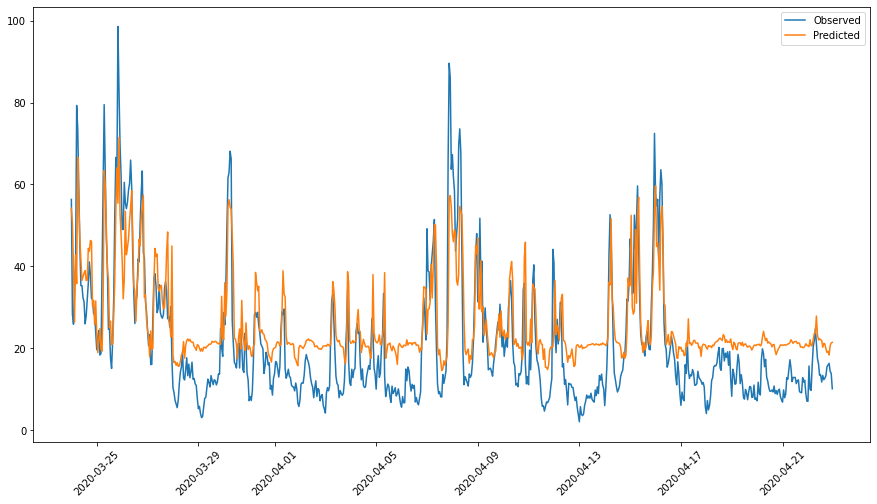

hb:24, ts:30, f:32, fs:2, n_seq:3, e:100, bs:32, c:24, vars:1, layers:3  
61, 0, RMSE:0.5668807029724121, MAPE: 0.6924424767494202 
62, 1, RMSE:0.5274782180786133, MAPE: 0.596467912197113 
63, 2, RMSE:0.5301170349121094, MAPE: 0.6504309177398682 


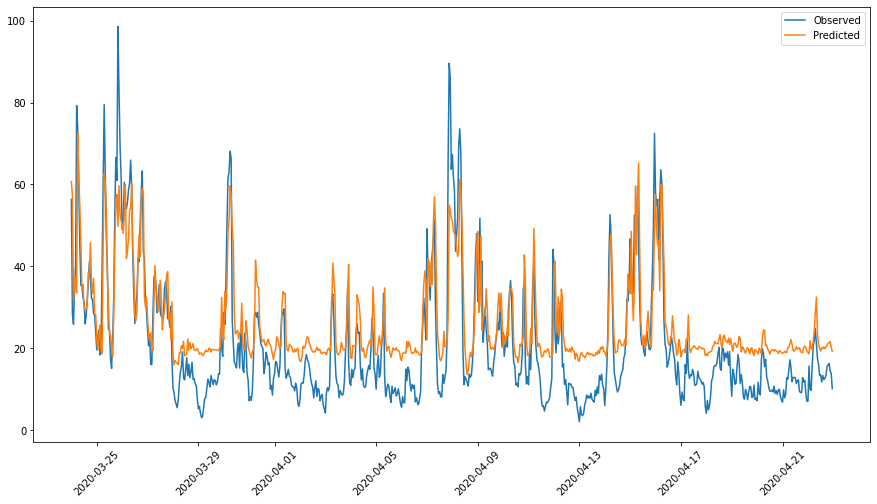

hb:24, ts:30, f:64, fs:2, n_seq:1, e:100, bs:32, c:24, vars:1, layers:3  
64, 0, RMSE:0.5573363900184631, MAPE: 0.5950716137886047 
65, 1, RMSE:0.5155491828918457, MAPE: 0.5763044953346252 
66, 2, RMSE:0.5951818227767944, MAPE: 0.690683126449585 


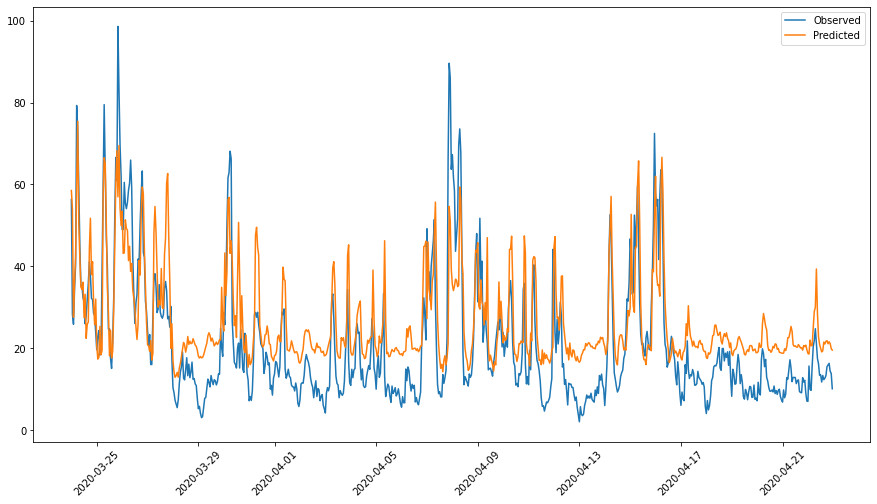

hb:24, ts:30, f:64, fs:2, n_seq:2, e:100, bs:32, c:24, vars:1, layers:3  
67, 0, RMSE:0.6123346090316772, MAPE: 0.7467349767684937 
68, 1, RMSE:0.5826612710952759, MAPE: 0.6989182233810425 
69, 2, RMSE:0.5711504220962524, MAPE: 0.6846945881843567 


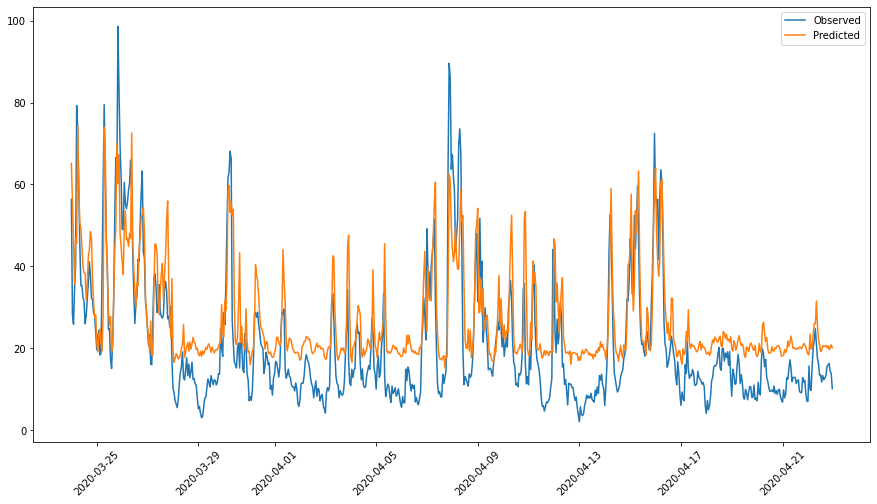

hb:24, ts:30, f:64, fs:2, n_seq:3, e:100, bs:32, c:24, vars:1, layers:3  
70, 0, RMSE:0.5349336862564087, MAPE: 0.614707887172699 
71, 1, RMSE:0.5442993640899658, MAPE: 0.59737628698349 
72, 2, RMSE:0.49129337072372437, MAPE: 0.5060691237449646 


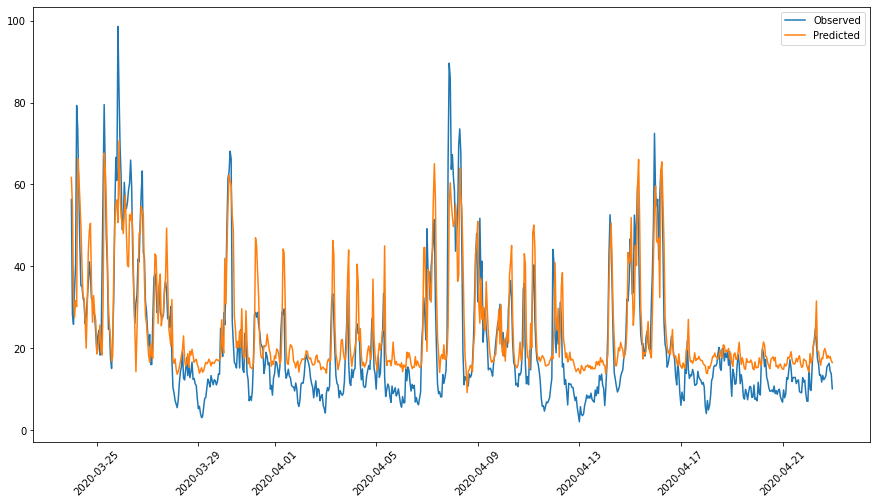

In [14]:
#-----------UPDATE PREDICTOR-----------
count = 0 
#---specify bounds of lag and prediction

for l in LAYERS:
    for f in FILTERS:
        for fs in FILTER_SIZE:
            for n in N_SEQ:
                for h in HOURS_BEFORE:
                    for b in BATCH_SIZE:
                        for c in CELLS:
                            for d in DROPOUT:
                                for e in EPOCHS:
                                    for t in TRAIN_SIZE:
                                        for v in VARIABLES[:1]:

                                            print (f"hb:{h}, ts:{t}, f:{f}, fs:{fs}, n_seq:{n}, e:{e}, bs:{b}, c:{c}, vars:{len(v)}, layers:{l}  ")

                                            dataset_copy = dataset[v]

                                            hours_before = h
                                            hours_after = TIMESTEPS

                                            days_before = 1
                                            days_after = 1

                                            # # specify the number of lag hours
                                            n_hours = hours_before * days_before # lag hours for each feature (t-x)
                                            n_features = len(v) # number of features 
                                            n_hours_out = hours_after * days_after # lenghth of output forecast (<1 == <t+1)

                                            date1 = DATE

                                            #convert values
                                            values = dataset_copy.values.astype('float32') 

                                            # frame as supervised learning
                                            reframed, names = series_to_supervised(values, n_hours, n_hours_out )


                                            train , test,  dates , leftover = split_by_date(dataset_copy, reframed, date1, t)

    #                                         print(train.shape, test.shape, dates.shape)

                                            n_seq = n
                                            n_steps = int( n_hours / n_seq )

                                            train_X, train_y, train_X_r = reshape(train, n_seq, n_steps, n_features)
                                            test_X, test_y, test_X_r = reshape(test, n_seq, n_steps, n_features)

    #                                         print( train_X_r.shape, test_X_r.shape)

    #                                         print ( train_X_r[0] ) 

                                            for rep in range (3):

                                                model = CNN_LSTM_model(c,f,fs,d,l)

                                                # fit network
                                                history = model.fit(train_X_r, train_y, epochs=e, batch_size=b, validation_split = 0.2 , verbose=0, shuffle=False)

                                                # get scaled prediction and observed values to calculate RMSE
                                                predicted = model.predict(test_X_r)[::n_hours_out]
                                                observed = test_y[::n_hours_out]

                                                #calculate RMSE
                                                RMSE = mean_squared_error(observed, predicted,squared = False)

                                                # rescale for plotting
                                                predicted_rescaled = inverse_scale(predicted.flatten(), mean, std)[:dates.shape[0]]
                                                observed_rescaled = inverse_scale(observed.flatten(), mean, std)[:dates.shape[0]]

                                                MAPE = mean_absolute_percentage_error(observed_rescaled,predicted_rescaled)


                                            #     #calculate mean RMSE for each timestep 
                                            #     lag_scores = np.array([mean_squared_error(observed_update[i],predicted_update[i], squared=False ) for i in range(observed_update.shape[0])])
                                            #     lag_scores = np.mean(lag_scores.reshape(int(observed_update.shape[0]/TIMESTEPS),TIMESTEPS),axis=0)


                                                results.append([h,t,f,fs,n,e, b, c, len(v),l, RMSE, MAPE] )
                                                count +=1 
                                                print(f'{count}, {rep}, RMSE:{RMSE}, MAPE: {MAPE} ')
                                                #plot 
                                                if rep == 2: 
                                                    plt.figure(figsize = (15,8))
                                                    plt.plot(dates[:24*plot_days],observed_rescaled[:24*plot_days],label='Observed')
                                                    plt.plot(dates[:24*plot_days],predicted_rescaled[:24*plot_days],label='Predicted')
                                                    plt.legend()
                                                    plt.xticks(rotation=45)
                                                    plt.show()

In [20]:
pd.DataFrame(np.vstack(results)).to_csv('./model_topology_comparison.csv')

In [ ]:
# # ----- ROLLING 1 HOUR PREDICTOR---------
# TIMESTEPS = 3

# #specify bounds of lag and prediction
# hours_before = 24
# hours_after = 1

# days_before = 1
# days_after = 1

# # # specify the number of lag hours
# n_hours = hours_before * days_before # lag hours for each feature (t-x)
# n_features = len(dataset.columns) # number of features 
# n_hours_out = hours_after * days_after # lenghth of output forecast (<1 == <t+1)

# date1 = DATE

# #convert values
# values = dataset.values.astype('float32') 

# # frame as supervised learning
# reframed, names = series_to_supervised(values, n_hours, n_hours_out )

# print(f'1h rolling Model will use last {n_hours} hours from {list(dataset.columns)} variables to predict {TIMESTEPS} ahead.')

# train , test,  dates , leftover = split_by_date( dataset, reframed, date1, TRAIN_SIZE )


# print ( dates.shape, test.shape ) 

# #print(train.shape, test.shape, dates.shape)

# train_X, train_y , train_X_r = reshape(train,n_features)
# test_X, test_y , test_X_r = reshape(test,n_features)

# print( train_X_r.shape, test_X_r.shape)


# for rep in range (1):

#     model = LSTM_model(CELLS,DROPOUT)

#     # fit network
#     history = model.fit(train_X_r, train_y, epochs = EPOCHS, batch_size=BATCH_SIZE, validation_split = 0.2 , verbose=0, shuffle=False)

#     #timesteps = how far ahead the rolling 1 hour predictor will forcast. 
#     # array of indexes  
#     indexes = np.arange(0,test_X_r.shape[0] - TIMESTEPS , TIMESTEPS)

#     # use rolling hour predictor to predict x timesteps ahead at each index within the array to get 
#     # contiguous predictions over a longer timeframe.
#     predicted = np.array([hour_predictor(test_X_r, i,  TIMESTEPS) for i in indexes]).flatten()
    
#     observed = test_y.flatten()[:predicted.shape[0]]

#     #invert scale and reshape for evaluation
#     predicted_rescaled = inverse_scale( predicted.reshape(len(predicted),1), mean, std )

#     #invert scale observed values, trim observed values so that predicted and observed have equal sizes and shape
#     observed_rescaled = inverse_scale(test_y.flatten()[:predicted.shape[0]],mean,std).reshape(predicted.shape[0],1)

#     #calculate RMSE
#     total_score = mean_squared_error(observed,predicted,squared = False)

# #     #calculate mean RMSE for each timestep 
# #     lag_scores = np.array([mean_squared_error(observed[i],predicted[i], squared=False ) for i in range(observed.shape[0])])
# #     lag_scores = np.mean(lag_scores.reshape(int(observed.shape[0]/TIMESTEPS),TIMESTEPS),axis=0)

# #     print (f"Rolling Predictor: Epochs: {EPOCHS}, Batch Size: {BATCH_SIZE}, TIMESTEP:{TIMESTEPS}, RMSE:{total_score}, Lag Scores {lag_scores}")
    
#     print ( total_score )
#     #trim dates 
#     #dates = dates[:predicted.shape[0]]
#     plt.figure(figsize = (15,8))
#     plt.plot(dates[:24*plot_days],observed_rescaled[:24*plot_days],label='Observed')
#     plt.plot(dates[:24*plot_days],predicted_rescaled[:24*plot_days],label='Predicted')
#     plt.legend()
#     plt.xticks(rotation=45)
#     plt.show()

In [ ]:
# def averager(array):
#     before = 0
#     after = array.shape[0]-1
#     results = []
#     for i in range(array.shape[0]):

#         before_array = np.zeros(before)
#         before_array[:] = np.nan

#         after_array = np.zeros(after)
#         after_array[:] = np.nan

#         results.append(np.concatenate((before_array, array[i], after_array)))

#         before = before + 1  
#         after= after - 1 

#     results = np.vstack(results)
    
#     return np.nanmean(results,axis=0), np.nanstd(results,axis=0)